In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Classification analysis

In [3]:
control = [
    "microsoft", "HuggingFaceTB"
]

treatment = [
    "deepseek-ai",
    "EleutherAI",
    "facebook",
    "lmsys",
    "Qwen"
]

In [33]:
data = pd.read_csv("validated/all_scores_predictions.csv")
data["Series"] = data.Model.str.split('/', n=1).str[0]
data.loc[data.Series.isin(control), 'Partition'] = 'Control'
data.loc[data.Series.isin(treatment), 'Partition'] = 'Treatment'
data.loc[data.Partition == 'Control', 'Gold'] = 0
data.loc[data.Partition == 'Treatment', 'Gold'] = 1

In [34]:
# store model size in millions for plotting
model_size = {
    'microsoft/Phi-3-small-128k-instruct': 7000,
    'microsoft/phi-2': 2700,
    'HuggingFaceTB/SmolLM2-360M-Instruct': 360,
    'microsoft/Phi-3.5-mini-instruct': 3800,
    'HuggingFaceTB/SmolLM2-1.7B-Instruct': 1700,
    'microsoft/Phi-3-medium-128k-instruct': 14000,
    'microsoft/Phi-4-mini-instruct': 3800,
    'HuggingFaceTB/SmolLM2-135M-Instruct': 135,
    'microsoft/phi-4': 14000,
    'facebook/opt-125m': 125,
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': 7000,
    'Qwen/Qwen2.5-0.5B-Instruct': 500,
    'lmsys/vicuna-13b-v1.3': 13000,
    'lmsys/vicuna-7b-v1.5': 7000,
    'EleutherAI/gpt-neo-1.3B': 1300,
    'Qwen/Qwen2.5-1.5B-Instruct': 1500,
    'facebook/opt-2.7b': 2700,
    'facebook/opt-6.7b': 6700,
    'EleutherAI/gpt-neo-125m': 125,
    'Qwen/Qwen2.5-7B-Instruct': 7000,
    'facebook/opt-1.3b': 1300,
    'EleutherAI/gpt-neo-2.7B': 2700,
    'facebook/opt-350m':350,
    'Qwen/Qwen2.5-3B-Instruct': 3000,
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B': 1500
}
for m, s in model_size.items():
    data.loc[data.Model == m, 'Size'] = s

data = data.sort_values(by=['Series', 'Size'])

In [74]:
classifiers = ["RandomForest"]

def accuracy_by_model_with_scale(data, clf):
    acc = dict()
    for series_name in data.Series.unique().tolist():
        acc[series_name] = dict()
        
    curr = f"{clf}_prediction"
    for model, group in data.groupby('Model'):
        curr_series = group.Series.unique()[0]
        correct = group.loc[group[curr] == group.Gold]
        curr_acc = round(len(correct) / group.shape[0], 4)
        acc[curr_series][model] = (curr_acc, group.shape[0])
    return acc



for clf in classifiers:
    gb_acc = accuracy_by_model_with_scale(data, "GradientBoosting")
    lr_acc = accuracy_by_model_with_scale(data, "LogisticRegression")
    rf_acc = accuracy_by_model_with_scale(data, "RandomForest")

In [77]:
from sklearn.metrics import roc_auc_score

In [82]:
for clf in classifiers:
    print(clf)
    print(roc_auc_score(data.Gold, data[f"{clf}_prediction"]))

GradientBoosting
0.7928986776698738
LogisticRegression
0.5999565426302464
RandomForest
0.9008421175308754


In [75]:
targets = ["HuggingFaceTB", "EleutherAI"]

for t in targets:
    print("GradientBoosting")
    print(gb_acc[t])
    print("LogisticRegression")
    print(lr_acc[t])
    print("RandomForest")
    print(rf_acc[t])
    print()

# gb_acc["HuggingFaceTB"]

GradientBoosting
{'HuggingFaceTB/SmolLM2-1.7B-Instruct': (0.6771, 3899), 'HuggingFaceTB/SmolLM2-135M-Instruct': (0.5479, 3508), 'HuggingFaceTB/SmolLM2-360M-Instruct': (0.5959, 3875)}
LogisticRegression
{'HuggingFaceTB/SmolLM2-1.7B-Instruct': (0.3167, 3899), 'HuggingFaceTB/SmolLM2-135M-Instruct': (0.1257, 3508), 'HuggingFaceTB/SmolLM2-360M-Instruct': (0.1886, 3875)}
RandomForest
{'HuggingFaceTB/SmolLM2-1.7B-Instruct': (0.8633, 3899), 'HuggingFaceTB/SmolLM2-135M-Instruct': (0.7779, 3508), 'HuggingFaceTB/SmolLM2-360M-Instruct': (0.8343, 3875)}

GradientBoosting
{'EleutherAI/gpt-neo-1.3B': (0.903, 3743), 'EleutherAI/gpt-neo-125m': (0.915, 3777), 'EleutherAI/gpt-neo-2.7B': (0.8939, 3742)}
LogisticRegression
{'EleutherAI/gpt-neo-1.3B': (0.8111, 3743), 'EleutherAI/gpt-neo-125m': (0.9251, 3777), 'EleutherAI/gpt-neo-2.7B': (0.7886, 3742)}
RandomForest
{'EleutherAI/gpt-neo-1.3B': (0.9557, 3743), 'EleutherAI/gpt-neo-125m': (0.9656, 3777), 'EleutherAI/gpt-neo-2.7B': (0.9519, 3742)}



In [70]:
gb_acc["EleutherAI"]

{'EleutherAI/gpt-neo-1.3B': (0.9030189687416511, 3743),
 'EleutherAI/gpt-neo-125m': (0.9150119142176331, 3777),
 'EleutherAI/gpt-neo-2.7B': (0.8939070016034206, 3742)}

GradientBoosting


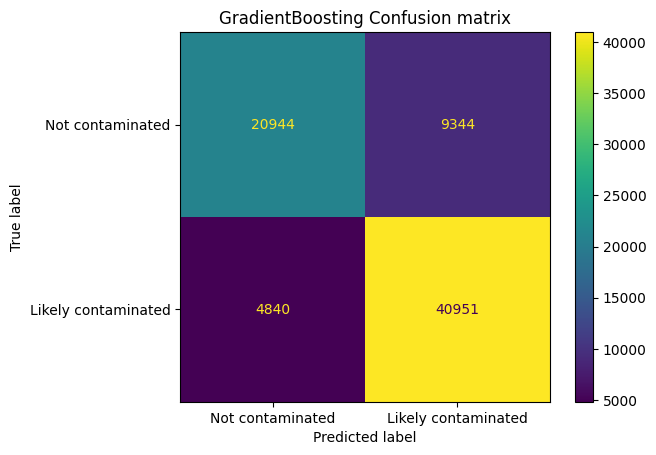

LogisticRegression


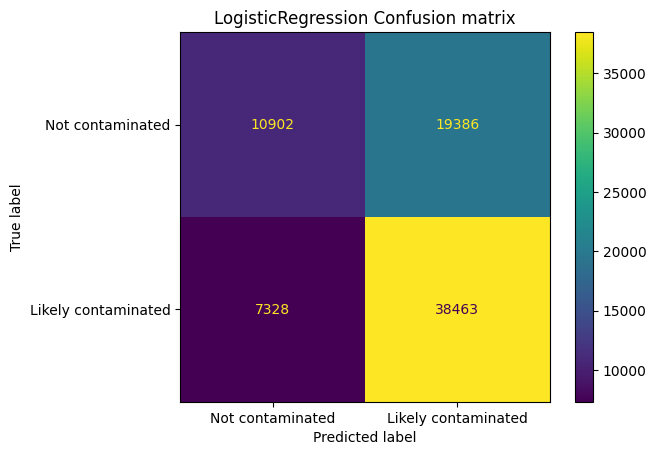

RandomForest


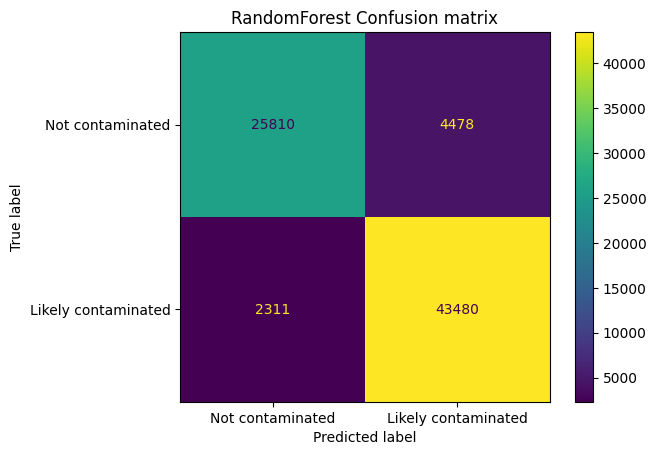

In [78]:
classifiers = ["GradientBoosting", "LogisticRegression", "RandomForest"]

# acc = dict()

for clf in classifiers:
    curr = f"{clf}_prediction"
    print(clf)
    cm = confusion_matrix(data.Gold, data[curr]) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not contaminated', 'Likely contaminated'])
    disp.plot()
    plt.title(f"{clf} Confusion matrix".format(int(size)))
    curr_fig = plt.gcf()
    plt.show()
    curr_fig.savefig(f"plots/confusion_{clf}.png", dpi=300, bbox_inches='tight')
    
    # correct = data.loc[data[curr] == data.Gold]
    # acc = len(correct) / data.shape[0]
    # print(acc)
    # for size, group in data.groupby('Size'):
    #     print(size)
    #     # correct = group.loc[group[curr] == group.Gold]

    #     cm = confusion_matrix(group.Gold, group[curr]) 
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not contaminated', 'Likely contaminated'])
    #     disp.plot()
    #     plt.title("Confusion matrix for models of size {} (in millions)".format(int(size)))
    #     curr_fig = plt.gcf()
    #     plt.show()
    #     curr_fig.savefig(f"plots/confusion_{int(size)}M.png", dpi=300, bbox_inches='tight')
        # print("{}\t{}".format(size, round(len(correct) / group.shape[0], 4)))
        # print()
        # for dataset, d_group in m_group.groupby('Dataset_Name'):
        #     print(dataset)
        #     correct = d_group.loc[d_group[curr] == d_group.Gold]
        #     print(len(correct) / d_group.shape[0])

In [26]:
len(data.Series.unique())

7

In [ ]:
data

In [6]:
_train, test = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
test.columns[test.isnull().any()]

Index(['Min_10.0%_Prob', 'Min_20.0%_Prob'], dtype='object')

In [8]:
test.GradientBoosting_prediction.value_counts()

GradientBoosting_prediction
1    10121
0     5095
Name: count, dtype: int64

In [16]:
classifier_colors = {'GradientBoosting': "c", 'LogisticRegression': "m", "RandomForest": "g"}
models = [m.replace("df", "").replace("_", " ").title() for m in data['Model'].unique()]
x = np.arange(len(models))
width=0.3

## D5 - plot small families min k prob

In [ ]:
data = pd.read_csv("./smol_gpt_opt_min_k_prob.csv")

In [ ]:
for source, data_g in data.groupby('source_dataset'):
    # create plot
    plt.figure(figsize=(8, 5))
    plt.title(f"Average Min-k prob for {source}")
    # loop over series
    for s_name, s_g in data_g.groupby('series'):
        for i, (k_val, gg) in enumerate(s_g.groupby('k')):
            x_positions = [models.index(m.replace("df", "").replace("_", " ").title()) for m in gg['model']]
            plt.bar(
                np.array(x_positions) + (i * width - width / 2),
                gg['average'],
                yerr=gg['std'],
                width=width,
                label=f"k={k_val}",
                color=series_colors[s_name],
                alpha=(0.8 - i * 0.3)
            )
    plt.xlabel("Model")
    # plt.ylabel("Average min-k prob")
    plt.xticks(x, models, rotation=45)  
    plt.ylim(3, 10.25)         
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.legend(k_colors.keys())
    curr_fig = plt.gcf()
    plt.show()
    curr_fig.savefig(f"plots/{source}_avg_min_k_prob_smol_gpt_opt.png", dpi=300, bbox_inches='tight')

In [ ]:
for source, data_g in data.groupby('source_dataset'):
    # create plot
    plt.figure(figsize=(8, 5))
    plt.title(f"Average Min-k prob for {source}")
    
    # loop over series
    for k_val, k_g in data_g.groupby('k'):
        for s_name, gg in k_g.groupby('series'):
            models = [m.replace("df", "").replace("_", " ").title() for m in gg['model']]
            plt.errorbar(
                # gg['size_millions'],
                # gg['model'],
                models,
                # gg['rank'],
                gg['average'],
                yerr=gg['std'],
                capsize=5,
                marker='o',
                linestyle='-',
                alpha=0.7,
                label=s_name,
                color=series_colors[s_name]
            )
        
    plt.xlabel("Model")
    # plt.ylabel("Average min-k prob")
    plt.xticks(rotation=45)
    plt.ylim(3, 9)         
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(series_colors.keys())
    plt.show()  # Show the plot for each dataset across all 3 model series

## Average metric reports

In [ ]:
dataset_name = "CNN-DailyMail"

In [ ]:
control = [
    "microsoft", "HuggingFaceTB"
]

treatment = [
    "deepseek-ai",
    "EleutherAI",
    "facebook",
    "lmsys",
    "Qwen"
]

In [ ]:
data = pd.read_csv(f"./validated/{dataset_name}_validated.csv")
data["Series"] = data.Model.str.split('/', n=1).str[0]
data.loc[data.Series.isin(control), 'Partition'] = 'Control'
data.loc[data.Series.isin(treatment), 'Partition'] = 'Treatment'

In [ ]:
score_names = [
    'cos_sim',
    'levenshtein',
    'min_k_Min_10.0_Prob',
    'min_k_Min_20.0_Prob',
    'min_k_Min_30.0_Prob',
    'min_k_Min_40.0_Prob',
    'min_k_Min_50.0_Prob',
    'rouge1_precision',
    'rouge1_recall',
    'rouge1_fmeasure',
    'rouge2_precision',
    'rouge2_recall',
    'rouge2_fmeasure',
    'rougeL_precision',
    'rougeL_recall',
    'rougeL_fmeasure'
]

In [ ]:
# store model size in millions for plotting
model_size = {
    'microsoft/phi-2': 2700,
    'HuggingFaceTB/SmolLM2-360M-Instruct': 360,
    'microsoft/Phi-3.5-mini-instruct': 3800,
    'HuggingFaceTB/SmolLM2-1.7B-Instruct': 1700,
    'microsoft/Phi-3-medium-128k-instruct': 0.128,
    'microsoft/Phi-4-mini-instruct': 3800,
    'HuggingFaceTB/SmolLM2-135M-Instruct': 135,
    'microsoft/phi-4': 14000,
    'facebook/opt-125m': 125,
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': 7000,
    'Qwen/Qwen2.5-0.5B-Instruct': 500,
    'lmsys/vicuna-13b-v1.3': 13000,
    'lmsys/vicuna-7b-v1.5': 7000,
    'EleutherAI/gpt-neo-1.3B': 1300,
    'Qwen/Qwen2.5-1.5B-Instruct': 1500,
    'facebook/opt-2.7b': 2700,
    'facebook/opt-6.7b': 6700,
    'EleutherAI/gpt-neo-125m': 125,
    'Qwen/Qwen2.5-7B-Instruct': 7000,
    'facebook/opt-1.3b': 1300,
    'EleutherAI/gpt-neo-2.7B': 2700,
    'facebook/opt-350m':350,
    'Qwen/Qwen2.5-3B-Instruct': 3000,
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B': 1500
}
for m, s in model_size.items():
    data.loc[data.Model == m, 'Size'] = s

data = data.sort_values(by=['Series', 'Size'])

In [ ]:
models = data.Model.unique().tolist()
x = np.arange(len(models))
width=0.3

In [ ]:
p_colors = {
    'Control': 'y',
    'Treatment': 'g'
}

In [ ]:

for score in score_names:
    plt.figure(figsize=(5, 5))
    plt.title(f"Average {score} report for {dataset_name}")
    
    for partition, p_data in data.groupby('Partition'):
        # for i, (series, s_data) in enumerate(p_data.groupby('Series')):
        p_data = p_data.sort_values(by='Size')

        # plot
        plt.bar(
                partition,
                round(p_data.loc[:, score].mean(), 4),
                # yerr=model_std,
                width=0.3,
                # capsize=5,
                # marker='o',
                # linestyle='-',
                color=p_colors[partition],
                label=partition
        )
    plt.xticks(rotation=45)  
    plt.show() 
    # curr_fig = plt.gcf()
    # plt.show()
    # curr_fig.savefig(f"plots/{dataset_name}_{score}_bars.png", dpi=300, bbox_inches='tight')

In [ ]:
for score in score_names:
    plt.figure(figsize=(15, 5))
    plt.title(f"Average {score} report for {dataset_name}")
    
    for partition, p_data in data.groupby('Partition'):
        for i, (series, s_data) in enumerate(p_data.groupby('Series')):
            s_data = s_data.sort_values(by='Size')
            # get model names for xticks
            model_names = s_data['Model'].unique().tolist()
            model_ticks = [models.index(m) for m in model_names]
            model_labels = [m.split("/")[1].replace("-", " ").title() for m in model_names]
                    
            # extract current score metrics
            model_metrics = [s_data.loc[s_data.Model == m, score] for m in model_names]
            model_avg = [round(mm.mean(), 4) for mm in model_metrics]
            model_std = [round(mm.std(), 4) for mm in model_metrics]
    
            # plot
            plt.bar(
                    model_labels,
                    model_avg,
                    # yerr=model_std,
                    width=width,
                    # capsize=5,
                    # marker='o',
                    # linestyle='-',
                    color=p_colors[partition],
                    label=series
            )
    plt.xticks(rotation=45, ha='right')  
    # plt.show() 
    curr_fig = plt.gcf()
    plt.show()
    curr_fig.savefig(f"plots/{dataset_name}_{score}_bars.png", dpi=300, bbox_inches='tight')

In [ ]:
score_types = {
    'cos_sim': 'cosine',
    'levenshtein': 'levenshtein',
    'min_k_Min_10.0_Prob': 'min_k',
    'min_k_Min_20.0_Prob': 'min_k',
    'min_k_Min_30.0_Prob': 'min_k',
    'min_k_Min_40.0_Prob': 'min_k',
    'min_k_Min_50.0_Prob': 'min_k',
    'rouge1_precision': 'rouge',
    'rouge1_recall': 'rouge',
    'rouge1_fmeasure': 'rouge',
    'rouge2_precision': 'rouge',
    'rouge2_recall': 'rouge',
    'rouge2_fmeasure': 'rouge',
    'rougeL_precision': 'rouge',
    'rougeL_recall': 'rouge',
    'rougeL_fmeasure': 'rouge'
}
score_ranges = {
    'cosine': (0, 1),
    'levenshtein': (50, 450),
    'min_k': (5, 15),
    'rouge': (0, 1)
}

### Generate plots

In [ ]:
# loop over scores
for score in score_names:
    plt.figure(figsize=(15, 5))
    plt.title(f"Average {score} report for {dataset_name}")
    # loop over series
    for series, s_data in data.groupby('Series'):
        s_data = s_data.sort_values(by='Size')
        # get model names for xticks
        model_names = s_data['Model'].unique()
        model_labels = [m.split("/")[1].replace("-", " ").title() for m in model_names]
                
        # extract current score metrics
        model_metrics = [s_data.loc[s_data.Model == m, score] for m in model_names]
        model_avg = [round(mm.mean(), 4) for mm in model_metrics]
        # model_std = [round(mm.std(), 4) for mm in model_metrics]

        # plot
        plt.plot(
                model_labels,
                model_avg,
                # yerr=model_std,
                # capsize=5,
                marker='o',
                linestyle='-',
                # alpha=0.7,
                label=series
        )
    
    plt.xlabel("Model series")
    # plt.ylabel("Average min-k prob")
    plt.xticks(rotation=45,ha='right')

    st = score_types[score]
    srx, sry = score_ranges[st]
    plt.ylim(srx, sry)         
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.legend(series_colors.keys())
    plt.show()  # Show the plot for each dataset across all 3 model series
    # curr_fig = plt.gcf()
    # plt.show()
    # curr_fig.savefig(f"plots/{dataset_name}_{score}_line.png", dpi=300, bbox_inches='tight')

### Sort by partition (control vs. treatment)

In [ ]:
result = pd.DataFrame()
col_namer = { i+1: s.replace("_", " ") for i, s in enumerate(score_names)}
col_namer[0] = 'Partition'

# loop over models in a group
for partition, s_data in data.groupby('Partition'):
    row = [partition]
    for score in score_names:
        # add the average value for each metric for this model
        metric = s_data.loc[:,score]
        avg = round(metric.mean(), 4)
        dev = round(metric.std(), 4)
        row.append("{} ± {}".format(avg, dev))
    temp = pd.DataFrame([row])
    result = pd.concat([result, temp])

# replace underscores and unnecessary symbols
result = result.rename(columns=col_namer, index=lambda c: str(c).replace("_", " "))
# use partition name as index
result = result.set_index('Partition')

In [ ]:
for name, g in result.groupby('Partition'):
    with open(f"tex/{dataset_name}_{name}_avg_metrics.tex", mode='w+') as writer:
        writer.write(g.T.to_latex(label="tab:", caption=f"Average metric values across the {name.lower()} subgroup for {dataset_name}"))

### Sort by model series

In [ ]:
result = pd.DataFrame()
col_namer = { i+2: s.replace("_", " ") for i, s in enumerate(score_names)}
col_namer[0] = 'Model'
col_namer[1] = 'Series'

# loop over models in a group
for series, s_data in data.groupby('Partition'):
    for model, m_data in s_data.groupby('Model'):
        row = [model, m_data['Series'].unique()[0]]
        for score in score_names:
            # add the average value for each metric for this model
            metric = m_data.loc[:,score]
            avg = round(metric.mean(), 4)
            dev = round(metric.std(), 4)
            row.append("{}±{}".format(avg, dev))
        temp = pd.DataFrame([row])
        result = pd.concat([result, temp])

# replace underscores and unnecessary symbols
result = result.rename(columns=col_namer, index=lambda c: str(c).replace("_", " "))
# use model names as index
# result = result.set_index(0)

In [ ]:
for name, g in result.groupby('Series'):
    curr = g.set_index('Model').drop(columns='Series')
    with open(f"tex/{dataset_name}_{name}_avg_metrics.tex", mode='w+') as writer:
        writer.write(curr.T.to_latex(label="tab:", caption=f"Average metric values across the {name.lower()} subgroup for {dataset_name}"))

In [ ]:
# # Treatment
df_deepseek_1_5b = pd.read_csv(f"./{dataset_name}/Treatment/results_deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B_{dataset_name}.csv")

df_gpt_neo_125m = pd.read_csv(f"./{dataset_name}/Treatment/results_EleutherAI_gpt-neo-125m_{dataset_name}.csv")
df_gpt_neo_1_3b = pd.read_csv(f"./{dataset_name}/Treatment/results_EleutherAI_gpt-neo-1.3B_{dataset_name}.csv")
df_gpt_neo_2_7b = pd.read_csv(f"./{dataset_name}/Treatment/results_EleutherAI_gpt-neo-2.7B_{dataset_name}.csv")

df_opt_125m = pd.read_csv(f"./{dataset_name}/Treatment/results_facebook_opt-125m_{dataset_name}.csv")
df_opt_1_3b = pd.read_csv(f"./{dataset_name}/Treatment/results_facebook_opt-1.3b_{dataset_name}.csv")
# df_opt_350m = pd.read_csv(f"./{dataset_name}/Treatment/results_facebook_opt-350m_{dataset_name}.csv")
df_opt_2_7b = pd.read_csv(f"./{dataset_name}/Treatment/results_facebook_opt-2.7b_{dataset_name}.csv")
df_opt_6_7b = pd.read_csv(f"./{dataset_name}/Treatment/results_facebook_opt-6.7b_{dataset_name}.csv")

df_vicuna_7b = pd.read_csv(f"./{dataset_name}/Treatment/results_lmsys_vicuna-7b-v1.5_{dataset_name}.csv")

# # Control
df_smol_1_7b = pd.read_csv(f"./{dataset_name}/Control/results_HuggingFaceTB_SmolLM2-1.7B-Instruct_{dataset_name}.csv")
df_smol_135m = pd.read_csv(f"./{dataset_name}/Control/results_HuggingFaceTB_SmolLM2-135M-Instruct_{dataset_name}.csv")
df_smol_360m = pd.read_csv(f"./{dataset_name}/Control/results_HuggingFaceTB_SmolLM2-360M-Instruct_{dataset_name}.csv")

df_phi_3_5 = pd.read_csv(f"./{dataset_name}/Control/results_microsoft_Phi-3.5-mini-instruct_{dataset_name}.csv")


In [ ]:
dfs = {
    "df_deepseek_1_5b": df_deepseek_1_5b,
    "df_gpt_neo_1_3b": df_gpt_neo_1_3b,
    "df_gpt_neo_125m": df_gpt_neo_125m,
    "df_gpt_neo_2_7b": df_gpt_neo_2_7b,
    "df_opt_1_3b": df_opt_1_3b,
    "df_opt_125m": df_opt_125m,
    "df_opt_2_7b": df_opt_2_7b,
    # "df_opt_350m": df_opt_350m,
    "df_opt_6_7b": df_opt_6_7b,
    "df_vicuna_7b": df_vicuna_7b,
    "df_smol_1_7b": df_smol_1_7b,
    "df_smol_135m": df_smol_135m,
    "df_smol_360m": df_smol_360m,
    "df_phi_3_5": df_phi_3_5
}

In [ ]:
gpt = ["df_gpt_neo_125m", "df_gpt_neo_1_3b", "df_gpt_neo_2_7b"]
# opt = ["df_opt_125m", "df_opt_350m", "df_opt_1_3b", "df_opt_2_7b", "df_opt_6_7b"]
opt = ["df_opt_125m", "df_opt_1_3b", "df_opt_2_7b", "df_opt_6_7b"]
vicuna = ["df_vicuna_7b"]
smol = ["df_smol_135m", "df_smol_360m", "df_smol_1_7b"]
phi = ["df_phi_3_5"]
treatment = gpt + opt + vicuna
contam = ["df_gpt_neo_125m", "df_opt_125m"]

series = {
    "gpt": gpt,
    "opt": opt,
    "vicuna": vicuna,
    "smol": smol,
    "phi": phi
}
# gpt = ["df_gpt_neo_1_3b", "df_gpt_neo_2_7b"]
# opt = ["df_opt_1_3b", "df_opt_2_7b"]

In [ ]:
score_names = df_deepseek_1_5b.drop(['Unnamed: 0', 'Model', 'Task_Prefix', 'Dataset_Name', 'Model_Responses', 'Gold_Labels'], axis=1).columns
score_names = list(score_names)

In [ ]:
k_values = ["40", "50"]

for k in k_values:
    for model in opt:
        print(model, k)
        temp = dfs[model]
        avg = round(temp['Min_{}.0%_Prob'.format(k)].mean(), 4)
        sd = round(temp['Min_{}.0%_Prob'.format(k)].std(), 4)
        print("avg: {}".format(avg))
        print("std: {}".format(sd))

# initial tables - statistical significance check

In [ ]:
df_gpt_pairs = pd.read_csv(f"./t_test/{dataset_name}/gpt_neo_.csv")
df_opt_pairs = pd.read_csv(f"./t_test/{dataset_name}/opt.csv")
df_smol_pairs = pd.read_csv(f"./t_test/{dataset_name}/smol.csv")
df_sus_con_pairs = pd.read_csv(f"./t_test/{dataset_name}/sus_con_compare.csv")

In [ ]:
df_opt_pairs

## initial tables - extract appendix score reports (means, stdevs)

## initial tables - length check

In [ ]:
from nltk import word_tokenize

In [ ]:
values = {"Model_Responses": ""}
for model in dfs:
    # dfs[model].fillna(value=values, inplace=True)
    dfs[model].dropna(subset=["Model_Responses"], inplace=True)

In [ ]:
for model in dfs:
    print(model)
    out = dfs[model].Model_Responses.apply(word_tokenize).apply(len)
    gold = dfs[model].Gold_Labels.apply(word_tokenize).apply(len)
    
    print("response avg. length {}".format(out.mean()))
    print("gold avg. length {}".format(gold.mean()))

In [ ]:
# score_ranges = {
#     "cosine": (-1, 1),
#     "levenshtein": (0, 15500),
#     "rouge1": (0, 1),
#     "rouge2": (0, 1),
#     "rougeL": (0, 1),
#     "min-k": (0, 20)
# }

In [ ]:
# score_types = {
#     'cos_sim_scores': 'cosine',
#     'levenshtein_distance': 'levenshtein',
#     'rouge1_precision': 'rouge1',
#     'rouge1_recall': 'rouge1',
#     'rouge1_f1': 'rouge1',
#     'rouge2_precision': 'rouge2',
#     'rouge2_recall': 'rouge2',
#     'rouge2_f1': 'rouge2',
#     'rougeL_precision': 'rougeL',
#     'rougeL_recall': 'rougeL',
#     'rougeL_f1': 'rougeL',
#     'Min_10.0%_Prob': "min-k",
#     'Min_20.0%_Prob': "min-k",
#     'Min_30.0%_Prob': "min-k",
#     'Min_40.0%_Prob': "min-k",
#     'Min_50.0%_Prob': "min-k"
# }


In [ ]:
# # loop over scores
# for score in score_names:
#     # determine score type and plot range
#     st = score_types[score]
#     sr = score_ranges[st]

#     # loop over series and models
#     for series_name, models in series.items(): 
#         plt.figure(figsize=(8, 5))
#         plt.title(f"{score} for {series_name.title()}")
        
#         means = [df_means[m][score][0] for m in models]
#         std_devs = [df_means[m][score][1] for m in models]
        
#         # Plot with error bars
#         plt.errorbar(models, means, yerr=std_devs, capsize=5, marker='o', linestyle='-',
#                      color=colors.get(score, "black"))

#         plt.xlabel("Model")
#         plt.ylabel("Value")
#         plt.xticks(rotation=45)
#         plt.ylim(sr[0], sr[1])  # Assuming values are between 0 and 1
#         plt.grid(axis='y', linestyle='--', alpha=0.7)
        
#         plt.show()  # Show the plot for each metric within the category
    